### Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).

In [1]:
# !wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('jamb_exam_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.drop(columns=['student_id'])
df = df.fillna(0)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [6]:
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

In [7]:
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* **`study_hours_per_week`**
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 22.13
* **42.13**
* 62.13
* 82.12

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_pred=y_pred, y_true=y_val)
rmse

42.13724207871227

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- **80**
- 200

In [13]:
scores = []
for est in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=est, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_pred=y_pred, y_true=y_val)
    scores.append((est, rmse))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

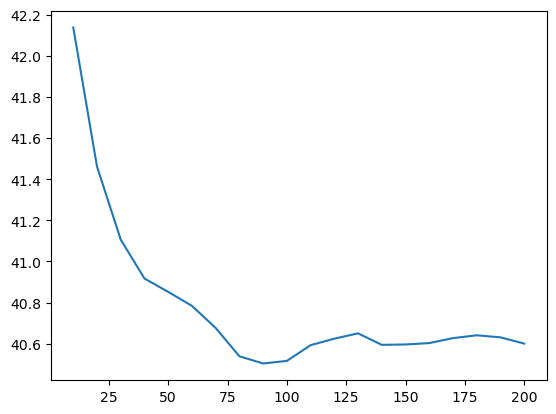

In [14]:
plt.plot(df_scores.n_estimators, df_scores.rmse);

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* **10**
* 15
* 20
* 25


In [15]:
scores = []
depths = [10, 15, 20, 25]
for depth in depths:
    for est in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_pred=y_pred, y_true=y_val)
        scores.append((depth, est, rmse))
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

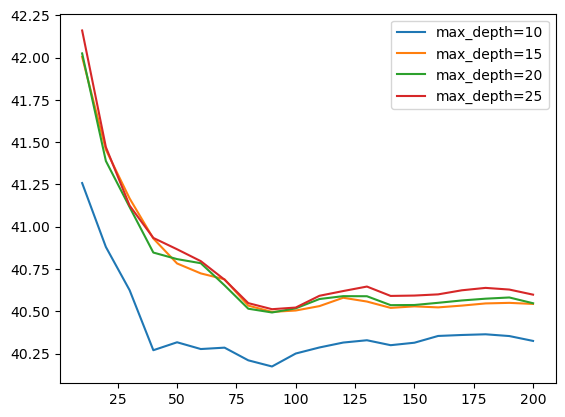

In [16]:
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label=f'max_depth={d}');

plt.legend();

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* **`study_hours_per_week`**
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`

In [17]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
importances = rf.feature_importances_
feat_names = dv.feature_names_
df_features_importances = pd.Series(rf.feature_importances_, index=feat_names)

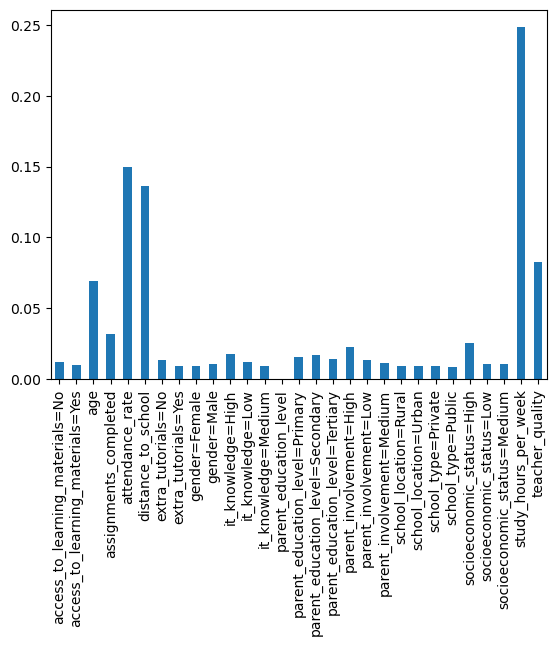

In [20]:
fig, ax = plt.subplots()
df_features_importances.plot.bar(ax=ax);

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1**
* Both give equal value

In [28]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [29]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [41]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [42]:
model = xgb.train(xgb_params,
            dtrain,
            num_boost_round=100,
            evals=watchlist,
            verbose_eval=10)
y_pred = model.predict(dval)
rmse = root_mean_squared_error(y_pred, y_val)
rmse

[0]	train-rmse:42.69552	val-rmse:44.86028
[10]	train-rmse:31.55119	val-rmse:40.83684
[20]	train-rmse:27.24424	val-rmse:41.80313
[30]	train-rmse:24.12906	val-rmse:42.28557
[40]	train-rmse:21.45994	val-rmse:42.77917
[50]	train-rmse:19.30407	val-rmse:43.11630
[60]	train-rmse:17.42414	val-rmse:43.40830
[70]	train-rmse:15.74173	val-rmse:43.77894
[80]	train-rmse:14.28350	val-rmse:44.08528
[90]	train-rmse:12.90222	val-rmse:44.30365
[99]	train-rmse:11.56417	val-rmse:44.43210


44.432098388671875

In [43]:
xgb_params['eta'] = 0.1
model = xgb.train(xgb_params,
            dtrain,
            num_boost_round=100,
            evals=watchlist,
            verbose_eval=10)
y_pred = model.predict(dval)
rmse = root_mean_squared_error(y_pred, y_val)
rmse

[0]	train-rmse:45.50072	val-rmse:46.99373
[10]	train-rmse:37.11353	val-rmse:41.55631
[20]	train-rmse:33.57997	val-rmse:40.37859
[30]	train-rmse:31.47315	val-rmse:40.20963
[40]	train-rmse:29.89807	val-rmse:40.15747
[50]	train-rmse:28.58793	val-rmse:40.28533
[60]	train-rmse:27.26360	val-rmse:40.55054
[70]	train-rmse:26.05959	val-rmse:40.73555
[80]	train-rmse:25.13835	val-rmse:40.82813
[90]	train-rmse:23.93958	val-rmse:40.89645
[99]	train-rmse:23.14487	val-rmse:41.04335


41.04335403442383